In [1]:
#all imports
import networkx as nx
import matplotlib.pyplot as plt
import random 
from string import ascii_lowercase
import numpy as np
import time
import random, operator, pandas as pd
from numpy.random import choice
from IPython.display import clear_output
import math
import datetime
from networkx.algorithms import tournament
from bokeh.models import CustomJS, Slider, Button
from bokeh.layouts import row, column
from bokeh.plotting import show
from bokeh.io import output_notebook
from datetime import timedelta, date
import warnings
warnings.simplefilter('ignore')

In [2]:
output_notebook()

#city class struct
class City:
    def __init__(self, key, name):
        self.key = key
        self.name = name
        self.start_date = random_date(START_DATE, END_DATE)
        self.end_date = random_date(self.start_date, END_DATE)
        self.delivered_date = None
    
    # calculate the time to go to another city in minute
    def time(self, city, currentTime):
        dist = nx.astar_path_length(G, self.key, city.key, None, "distance")
        nodesCrossed = len(nx.astar_path(G, self.key, city.key, None, None))-1
        cityCrossedList = nx.astar_path(G, self.key, city.key, None, None)
        
        lastCity = self.key
        totalTraficAmount = 0
        for i in range (0, len(cityCrossedList) -1):
            for road in roadList:
                if ((road.id_city_1 == cityCrossedList[i]) and (road.id_city_2 == cityCrossedList[i+1])) or ((road.id_city_2 == cityCrossedList[i]) and (road.id_city_1 == cityCrossedList[i+1])):
                    for tr in road.traficList:
                        if tr.date == currentTime:
                            totalTraficAmount = totalTraficAmount + tr.nbr_vehicules
                            break
                            
        trafic_coef = (((totalTraficAmount / nodesCrossed) * 10) / MAX_TRAFIC)
        timeToReturn = (dist * trafic_coef) * COEF_TIME
        return int(timeToReturn) + 1
    
    def availability(self):
        return "(" + self.start_date.strftime("%H:%M") + " => " + self.end_date.strftime("%H:%M") +")"
    
    def __repr__(self):
        return "(City :" + self.name + "; with key: " + str(self.key) + ")"
    
class Route:
    def __init__(self, cityList, path):
        if(cityList == None):
            self.path = path
        else:  
            self.path = self.generatePath(cityList)
        self.currentTime = START_DATE
        self.reportedDelivery = 0
        self.delivered_dates = []
        self.cityBanned = []
    
    def generatePath(self, cityList):
        path = random.sample(cityList, len(cityList))
        return path
    
    def __repr__(self):
        return "(Path :" + str(len(self.path)) + "; Current Time: " + str(self.currentTime.strftime("%Y-%m-%d")) + ")"
             
class Road:
    def __init__(self, key, id_city_1, id_city_2):
        self.key = key
        self.id_city_1 = id_city_1
        self.id_city_2 = id_city_2
        self.trafic = random.randint(MIN_TRAFIC, MAX_TRAFIC)
        self.traficList = self.generateTraficList()
            
    def generateTraficList(self):
        tL = []
        start_date = START_DATE
        end_date = END_DATE
        delta = timedelta(minutes=1)
        while start_date <= end_date:
            nbrCars = random.randint(MIN_TRAFIC,MAX_TRAFIC)
            if (timedelta(hours=7) <= timedelta(hours=start_date.hour) < timedelta(hours=9)) or (timedelta(hours=17) <= timedelta(hours=start_date.hour) < timedelta(hours=19)):
                nbrCars = nbrCars * SCALE_TRAFIC
            trafic = Trafic(self.key,start_date,nbrCars)
            tL.append(trafic)
            start_date += delta
        return tL
        

    def __repr__(self):
        return "(Road :" + str(self.key) + "; City 1 => " + str(self.id_city_1) + "; City 2 => " + str(self.id_city_2) + ")"

class Trafic:
    def __init__(self, id_road, date, nbr_vehicules):
        self.id_road = id_road
        self.date = date
        self.nbr_vehicules = nbr_vehicules

    def __repr__(self):
        return "(Trafic : Road:" + self.id_road + "; Date:" + str(self.date) + "; Nombre de véhicules: " + str(self.nbr_vehicules) + ")"
        
#class to calcul the route distance then the fitness value
class Fitness:
    def __init__(self, route):
        self.route = route
        self.time = 0
        self.fitness = 0.0
    
    def routeTime(self):
        self.route.currentTime = START_DATE
        self.route.reportedDelivery = 0
        self.route.delivered_dates = []
        self.route.cityBanned = []
        
        if self.time == 0:
            pathTime = 0
            # on ajoute le temps pour la 1ere ville partant du dépot
            startCity = depot
            toCity = self.route.path[0]
            timeToGo = startCity.time(toCity,self.route.currentTime)
            arrivedExpected = self.route.currentTime + timedelta(minutes=timeToGo)
            timeToWait = toCity.start_date - arrivedExpected
            deltatime = int(timeToWait.seconds/60) + timeToGo
            self.route.currentTime += timedelta(minutes=deltatime)
            self.route.delivered_dates.append(self.route.currentTime)
            pathTime += deltatime
            
            for i in range(len(self.route.path)):
                deltaTime = 0
                fromCity = self.route.path[i]
                toCity = None
                if i + 1 < len(self.route.path):
                    toCity = self.route.path[i + 1]
                else:
                    toCity = self.route.path[0]

                # on cacul l'heure d'arrviée pour ensuite vérifier si la ville est disponible
                timeToGo = fromCity.time(toCity,self.route.currentTime)
                arrivedExpected = self.route.currentTime + timedelta(minutes=timeToGo)
                
                if(arrivedExpected > toCity.end_date and i + 1 < len(self.route.path)):
                    # colis non délivré => reporté à demain
                    self.route.cityBanned.append(toCity.key)
                    self.route.reportedDelivery += 1
                elif(arrivedExpected < toCity.start_date):
                    # colis délivré avec une attente de timeToWait minute
                    timeToWait = toCity.start_date - arrivedExpected
                    # on ajoute le temps attendus 
                    deltaTime += int(timeToWait.seconds/60) + timeToGo
                else:
                    # colis délivré
                    deltaTime += timeToGo
                
                self.route.currentTime += timedelta(minutes=deltaTime)
                if(deltaTime > 0 and i + 1 < len(self.route.path)):
                    self.route.delivered_dates.append(self.route.currentTime)
                pathTime += deltaTime
            
            # temps réel de livraison
            self.time = pathTime
            
            # temps de livraison avec un ajout de pénalité ppur la prochaine génération
            penalityTime = self.route.reportedDelivery / len(self.route.path) + 1
            
        return self.time * penalityTime
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeTime())
        return self.fitness

def initialPopulation(popSize, cityList):
    population = []
    for i in range(0, popSize):
        population.append(Route(cityList, None))
    return population

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

def selectOne(popRanked):
    max = sum([indiv[1] for indiv in popRanked])
    selection_probs = [indiv[1]/max for indiv in popRanked]
    return popRanked[choice(len(popRanked), p=selection_probs)][0]

def selection(popRanked, eliteSize):
    selectionResults = []
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    
    for i in range(0, len(popRanked) - eliteSize):
        indiv = selectOne(popRanked);
        selectionResults.append(indiv)
        
    return selectionResults

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

def crossover(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1.path))
    geneB = int(random.random() * len(parent1.path))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1.path[i])
        
    childP2 = [item for item in parent2.path if item not in childP1]

    child = childP1 + childP2
    return Route(None,child)

def crossoverPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = crossover(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

def mutate(path, mutationRate):
    for swapped in range(len(path)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(path))
            
            city1 = path[swapped]
            city2 = path[swapWith]
            
            path[swapped] = city2
            path[swapWith] = city1
    return path

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    for i in range(0, len(population)):
        mutatedIndividual = population[i]
        mutatedIndividual.path = mutate(mutatedIndividual.path, mutationRate)
        mutatedPop.append(mutatedIndividual)
    return mutatedPop

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = crossoverPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    stats = []
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        bestRouteIndex = rankRoutes(pop)[0][0]
        bestRoute = pop[bestRouteIndex]
        bestRouteTime = Fitness(bestRoute).routeTime()
        stats.append(bestRouteTime)
        clear_output(True)
        print("Génération: n°" + str(i))
        print("Distance min: " + str(bestRouteTime))

    data = nx.readwrite.json_graph.node_link_data(G)
    labels[0] += "\n Arrivèe à " + bestRoute.currentTime.strftime("%H:%M")
    #TODO STORE GRAPH IN MONGO DB
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    print("Début de la livraison: " + str(START_DATE))
    print("Fin de la livraison: " + str(bestRoute.currentTime))
    print("Report de livraison: " + str(bestRoute.reportedDelivery))
    
    displayGraph(bestRoute)
    displayHistogram(stats)
    return bestRoute

#to reload cities name file txt
def reloadCitiesName():
    citiesName = []
    try:
        with open('FrenchCitieslist.txt', 'rU') as infile:
            wordSet = set(line.strip() for line in infile)
    except IOError:
           print('error opening file')

    for aWord in wordSet:
        citiesName.append(aWord)
    return citiesName

def random_date(start, end):
    delta = end - start
    int_delta = delta.seconds
    random_second = random.randrange(int_delta)
    return start + timedelta(seconds=random_second)

def displayGraph(bestRoute):
    edges = []
    path = [node for node in bestRoute.path if node.key not in bestRoute.cityBanned]
    path.append(path[0])
    edges.append((depot.key, path[0].key))
    for i in range(len(path)-1):
        city = path[i]
        if(i < len(bestRoute.delivered_dates)):
            labels[city.key]= labels[city.key] + "\n Passage: n°" + str(i+1) + " à " + bestRoute.delivered_dates[i].strftime("%H:%M")
        nodesCrossed = nx.astar_path(G, city.key, path[i+1].key, None, None)
        if(len(nodesCrossed)-1 == 1):
            edges.append((path[i].key, path[i+1].key))
        else:
            for j in range(len(nodesCrossed)-1):
                edges.append((nodesCrossed[j], nodesCrossed[j+1]))
    
    plt.figure(figsize=(15, 15))
    plt.title("Carte routière")
    ax = plt.subplot(1,1,1)
    edge_labels = dict([((u,v),"Dist: " + str(d['distance'])) for u,v,d in G.edges(data=True)])    
    nx.draw_networkx(G,pos, node_size=200,node_color="skyblue", alpha=0.5,node_shape="s", linewidths=30, ax =ax)
    nx.draw_networkx(G,pos, nodelist=bestRoute.cityBanned, node_size=200,node_color="r", alpha=0.5,node_shape="s", linewidths=30, ax =ax)
    nx.draw_networkx(G,pos, nodelist=[depot.key], node_size=200,node_color="green", alpha=0.5,node_shape="s", linewidths=30, ax =ax)
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color="red", ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos, labels,font_size=10,font_weight='bold')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.axis("off")
    plt.show()

def displayHistogram(stats):
    a = np.array(stats) 
    plt.plot([i for i in range(GENERATIONS)], stats, '-o')
    plt.xlim(0, GENERATIONS);
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Générations')
    plt.ylabel('Time minimized')
    plt.title('GA Histogram')
    plt.figure(figsize=(15, 15))
    plt.text(23, 45, r'$\mu=15, b=3$')
    plt.show()
    
def main():
    citiesName = reloadCitiesName()
    
    # add distance and traffic on each edge randomly
    
    for u,v in G.edges():
        road = Road(len(roadList),u,v)
        G.edges[u,v]["distance"] = random.randint(1, 10)
        G.edges[u,v]["trafic"] = road.trafic
        roadList.append(road)
        print("EDGE : id_1 = "+ str(u) + " id_2 = " + str(v) + " ROAD : id_1 = " + str(road.id_city_1) + " id_2 = " + str(road.id_city_2))
        clear_output(True)
    
    #iterator to add depot at first position
    for n in G.nodes():
        #remove depot from cityList
        global depot
        if(n == 0):
            labels[0] = DEPOT_LABEL + "\n Départ à " + START_DATE.strftime("%H:%M")
            depot = City(n, DEPOT_LABEL)
            continue
        #condition to add depot
        selection = random.randint(0, len(citiesName)-1)
        name = citiesName.pop(selection)
        newCity = City(n, name)
        labels[n] = newCity.name + newCity.availability()
        cityList.append(newCity)
    
    geneticAlgorithm(population=cityList,popSize=POPSIZE,eliteSize=ELITESIZE,mutationRate=MUTATIONRATE,generations=GENERATIONS)
    




Loading BokehJS ...

Génération: n°99
Distance min: 1311.0
Final distance: 1311.0
Début de la livraison: 2020-01-01 00:00:00
Fin de la livraison: 2020-01-01 21:51:00
Report de livraison: 0


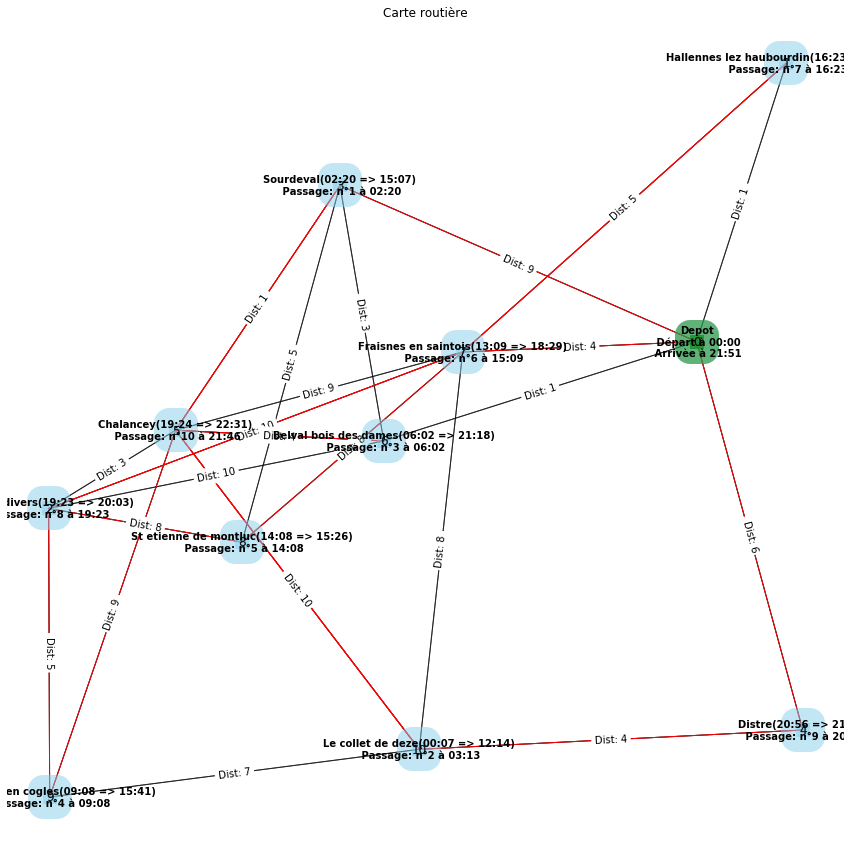

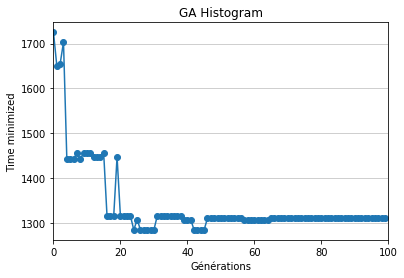

Time of Execution :
Wall time: 1min 39s


In [3]:
%%time 

NBR_CITIES = 10
COEF_TIME = 10/NBR_CITIES 
NBR_DEPOT = 1
DEPOT_LABEL = "Depot"
MAX_TRAFIC = 20
MIN_TRAFIC = 0
SCALE_TRAFIC = 5
NBR_NEAREST_NEIGHBORS = 4
REWIRING_PROBABILITY = 1
POPSIZE =  50
ELITESIZE = 10
MUTATIONRATE = 0.03
GENERATIONS = 100

START_DATE = datetime.datetime(2020,1, 1, 0, 0)
END_DATE = datetime.datetime(2020,1, 1, 23, 0)

depot = None
roadList = []
cityList = []
labels = {}
G = nx.connected_watts_strogatz_graph(NBR_CITIES+NBR_DEPOT,NBR_NEAREST_NEIGHBORS,REWIRING_PROBABILITY)
#G_data = nx.readwrite.json_graph.node_link_data(H)
#G = nx.readwrite.json_graph.node_link_graph(G_data)

pos = nx.spring_layout(G)

main()

print("Time of Execution :") #don't delete, using magic cell statement